<a href="https://colab.research.google.com/github/Soochin/cs175-project/blob/master/notebooks/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Final Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final Project


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import dill
import numpy as np
import io
import os
import timeit
import random
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Loading

In [0]:
class HandClassifyDataset(torch.utils.data.Dataset):
  def __init__(self, rootdir):
    self.rootdir = rootdir
    self.handsdir = self.rootdir+'hands_dataset_t_128/'
    self.nohandsdir = self.rootdir+'nohands_dataset_t_128/'
    self.handIms = []
    self.nohandIms = []
    i = 0
    for batch in os.listdir(self.handsdir):
      if "batch" in batch:
        t = torch.load(self.handsdir+batch)
        print(t.size())
        self.handIms.append(t)
        print('Batch done')
    self.handIms = torch.cat(self.handIms, 0)
    print(self.handIms.size())
    for batch in os.listdir(self.nohandsdir):
      if "batch" in batch:
        t = torch.load(self.nohandsdir+batch)
        print(t.size())
        self.nohandIms.append(t)
        print('Batch done')
    self.nohandIms = torch.cat(self.nohandIms, 0)
    print(self.nohandIms.size())
    self.ind = [x for x in range(self.handIms.size()[0]+ self.nohandIms.size()[0])]
    random.shuffle(self.ind)
    
  def __len__(self):
    return self.handIms.size()[0]+self.nohandIms.size()[0]
  
  def __getitem__(self, idx):
    idx = self.ind[idx]
    if idx < self.handIms.size()[0]:
      sample = (self.handIms[idx,:,:,:], 1)
      return sample
    elif idx < self.handIms.size()[0] + self.nohandIms.size()[0]:
      idx = idx-self.handIms.size()[0]
      sample = (self.nohandIms[idx,:,:,:], 0)
      #print(handBoxes[handFiles[idx]].size())
      return sample
    else:
      raise IndexError

In [0]:
hands_dataset = HandClassifyDataset(rootdir='./data/')

torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([49, 3, 128, 128])
Batch done
torch.Size([4049, 3, 128, 128])
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([1000, 3, 128, 128])
Batch done
torch.Size([219, 3, 128, 128])
Batch done
torch.Size([4219, 3, 128, 128])


## Split Data to Train/Validation/Testing

In [0]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
hands_dataset_size = len(hands_dataset)
NUM_VAL = int(np.ceil(0.12*hands_dataset_size))
NUM_TEST = int(np.ceil(0.13*hands_dataset_size))
NUM_TRAIN = len(hands_dataset)-NUM_VAL-NUM_TEST

In [0]:
train_loader = torch.utils.data.DataLoader(hands_dataset, batch_size=64, num_workers=4, sampler=ChunkSampler(NUM_TRAIN, 0))
val_loader = torch.utils.data.DataLoader(hands_dataset, batch_size=64, num_workers=4, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))
test_loader = torch.utils.data.DataLoader(hands_dataset, batch_size=64, num_workers=4, sampler=ChunkSampler(NUM_TEST, NUM_TRAIN+NUM_VAL))

## Check GPU Availability

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Hyper Parameters

In [0]:
num_epochs = 15
num_classes = 2
batch_size = 100
learning_rate = 1e-3

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32768, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=2, bias=True)
)


In [0]:
train_loss = list()
valid_loss = list()
models = list()

loss_tr = 0

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train() # train mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss_tr = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss_tr.backward()
        optimizer.step()
        
        if (i+1) % 30 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss_tr.item()))
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validation Accuracy of the model on the {} validation images: {} %'.format(total, 100 * correct / total))
            
    train_loss.append(loss_tr.item())
    valid_loss.append(1 - (correct / total))
    models.append(model.state_dict())

Epoch [1/15], Step [30/97], Loss: 0.7571
Epoch [1/15], Step [60/97], Loss: 0.9905
Epoch [1/15], Step [90/97], Loss: 0.5564
Validation Accuracy of the model on the 993 validation images: 69.78851963746223 %
Epoch [2/15], Step [30/97], Loss: 0.4957
Epoch [2/15], Step [60/97], Loss: 0.6349
Epoch [2/15], Step [90/97], Loss: 0.4245
Validation Accuracy of the model on the 993 validation images: 64.14904330312186 %
Epoch [3/15], Step [30/97], Loss: 0.4867
Epoch [3/15], Step [60/97], Loss: 0.4914
Epoch [3/15], Step [90/97], Loss: 0.3677
Validation Accuracy of the model on the 993 validation images: 59.01309164149043 %
Epoch [4/15], Step [30/97], Loss: 0.4657
Epoch [4/15], Step [60/97], Loss: 0.3065
Epoch [4/15], Step [90/97], Loss: 0.2369
Validation Accuracy of the model on the 993 validation images: 68.37865055387714 %
Epoch [5/15], Step [30/97], Loss: 0.3165
Epoch [5/15], Step [60/97], Loss: 0.1726
Epoch [5/15], Step [90/97], Loss: 0.1815
Validation Accuracy of the model on the 993 validatio

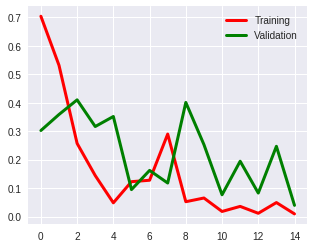

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

x = range(0, len(train_loss))

ax.plot(x, train_loss, 'r-', lw=3, label='Training')
ax.plot(x, valid_loss, 'g-', lw=3, label='Validation')
ax.legend()

plt.show()

In [0]:
best_model_index = np.argmin(valid_loss)
best_state_dict = models[best_model_index]
model.load_state_dict(best_state_dict)

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 1075 test images: 95.53488372093024 %


In [0]:
torch.save(model.state_dict(), 'model.ckpt')